# Trabajo Final de Biología de Sistemas 

- Antonio Elias Sánchez Soto
- Daniela Vento
- Yonathan Villavicencio

## Carga del conjunto de datos

Al revisar el txt previamente se muestran las células y los conteos de genes como una matriz de expresión, es necesario trasponer para tener células x genes

In [96]:
import os
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

In [97]:
# configuracion para resultados
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=120, figsize=(6, 5))
OUTPUT_DIR = "results_scRNA"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [98]:
fn = "wt_eco_sp2.txt"
df = pd.read_csv(fn, sep=r"\s+", index_col=0)
print(df.shape)


(27998, 6076)


In [99]:
df.head()

AAACCTGAGCTAGGCA  AAACCTGAGGGCACTA  AAACCTGAGTAGGTGC  \
Xkr4                    0                 0                 0   
Gm1992                  0                 0                 0   
Gm37381                 0                 0                 0   
Rp1                     0                 0                 0   
Rp1.1                   0                 0                 0   

         AAACCTGAGTTAACGA  AAACCTGCAAGCCATT  AAACCTGCAATTGCTG  \
Xkr4                    0                 0                 0   
Gm1992                  0                 0                 0   
Gm37381                 0                 0                 0   
Rp1                     0                 0                 0   
Rp1.1                   0                 0                 0   

         AAACCTGCACGACGAA  AAACCTGCATACAGCT  AAACCTGCATCGGGTC  \
Xkr4                    0                 0                 0   
Gm1992                  0                 0                 0   
Gm37381                 0                 0                 0   
Rp1                     0                 0                 0   
Rp1.1                   0                 0                 0   

         AAACCTGCATTACCTT  ...  TTTGTCAAGCCAGAAC  TTTGTCACACCACGTG  \
Xkr4                    0  ...                 0                 0   
Gm1992                  0  ...                 0                 0   
Gm37381                 0  ...                 0                 0   
Rp1                     0  ...                 0                 0   
Rp1.1                   0  ...                 0                 0   

         TTTGTCACAGCGTAAG  TTTGTCAGTCCGTGAC  TTTGTCAGTCTAACGT  \
Xkr4                    0                 0                 0   
Gm1992                  0                 0                 0   
Gm37381                 0                 0                 0   
Rp1                     0                 0                 0   
Rp1.1                   0                 0                 0   

         TTTGTCAGTTGGTAAA  TTTGTCATCCACGTTC  TTTGTCATCGCTAGCG  \
Xkr4                    0                 0                 0   
Gm1992                  0                 0                 0   
Gm37381                 0                 0                 0   
Rp1                     0                 0                 0   
Rp1.1                   0                 0                 0   

         TTTGTCATCGGATGGA  TTTGTCATCTCTAAGG  
Xkr4                    0                 0  
Gm1992                  0                 0  
Gm37381                 0                 0  
Rp1                     0                 0  
Rp1.1                   0                 0  

[5 rows x 6076 columns]

Se muestran como genes x células en el dataset. Para el análisis es necesario transponer y convertir en un AnnData, una estructura especializada para problemas de singleCell, que guarda metadatos valiosos.

In [100]:
adata = sc.AnnData(df.T)  # ahora obs = células, var = genes
print(adata)


AnnData object with n_obs × n_vars = 6076 × 27998


## QC: métricas básicas

Típicamente antes de la limpieza se aplican las métricas de calidad donde son evaluados los conteos de células y el porcentaje mitocondrial.

In [101]:

adata.var["mt"] = adata.var_names.str.upper().str.startswith("MT-")

sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=["mt"],
    percent_top=None,
    log1p=False, # no estan normalizados aun
    inplace=True,
)


In [102]:
# Guardar resumen estadístico
qc_summary = adata.obs[["n_genes_by_counts", "total_counts", "pct_counts_mt"]].describe()
qc_summary.to_csv(os.path.join(OUTPUT_DIR, "qc_summary_before_filtering.csv"))
print(qc_summary)

       n_genes_by_counts  total_counts  pct_counts_mt
count        6076.000000   6076.000000    6076.000000
mean         1964.253785   8482.491935       1.927124
std           805.687898   5608.977891       1.139059
min           779.000000   3471.000000       0.022821
25%          1388.000000   5079.750000       1.223945
50%          1801.000000   6897.500000       2.048842
75%          2278.250000   9776.250000       2.524386
max          6563.000000  64943.000000      20.492662


Interpretación: 
- Hay un mínimo de 779 genes por células
- La mayoría de las células tienen profundidades razonables según el cuartil 25% y 75%, sin embargo, existen outliers por el máximo que se muestra 
- La mayoría de las células tiene poco contenido mitocondrial (alrededor del 2%), sin embargo, hay un máximo de 20.49

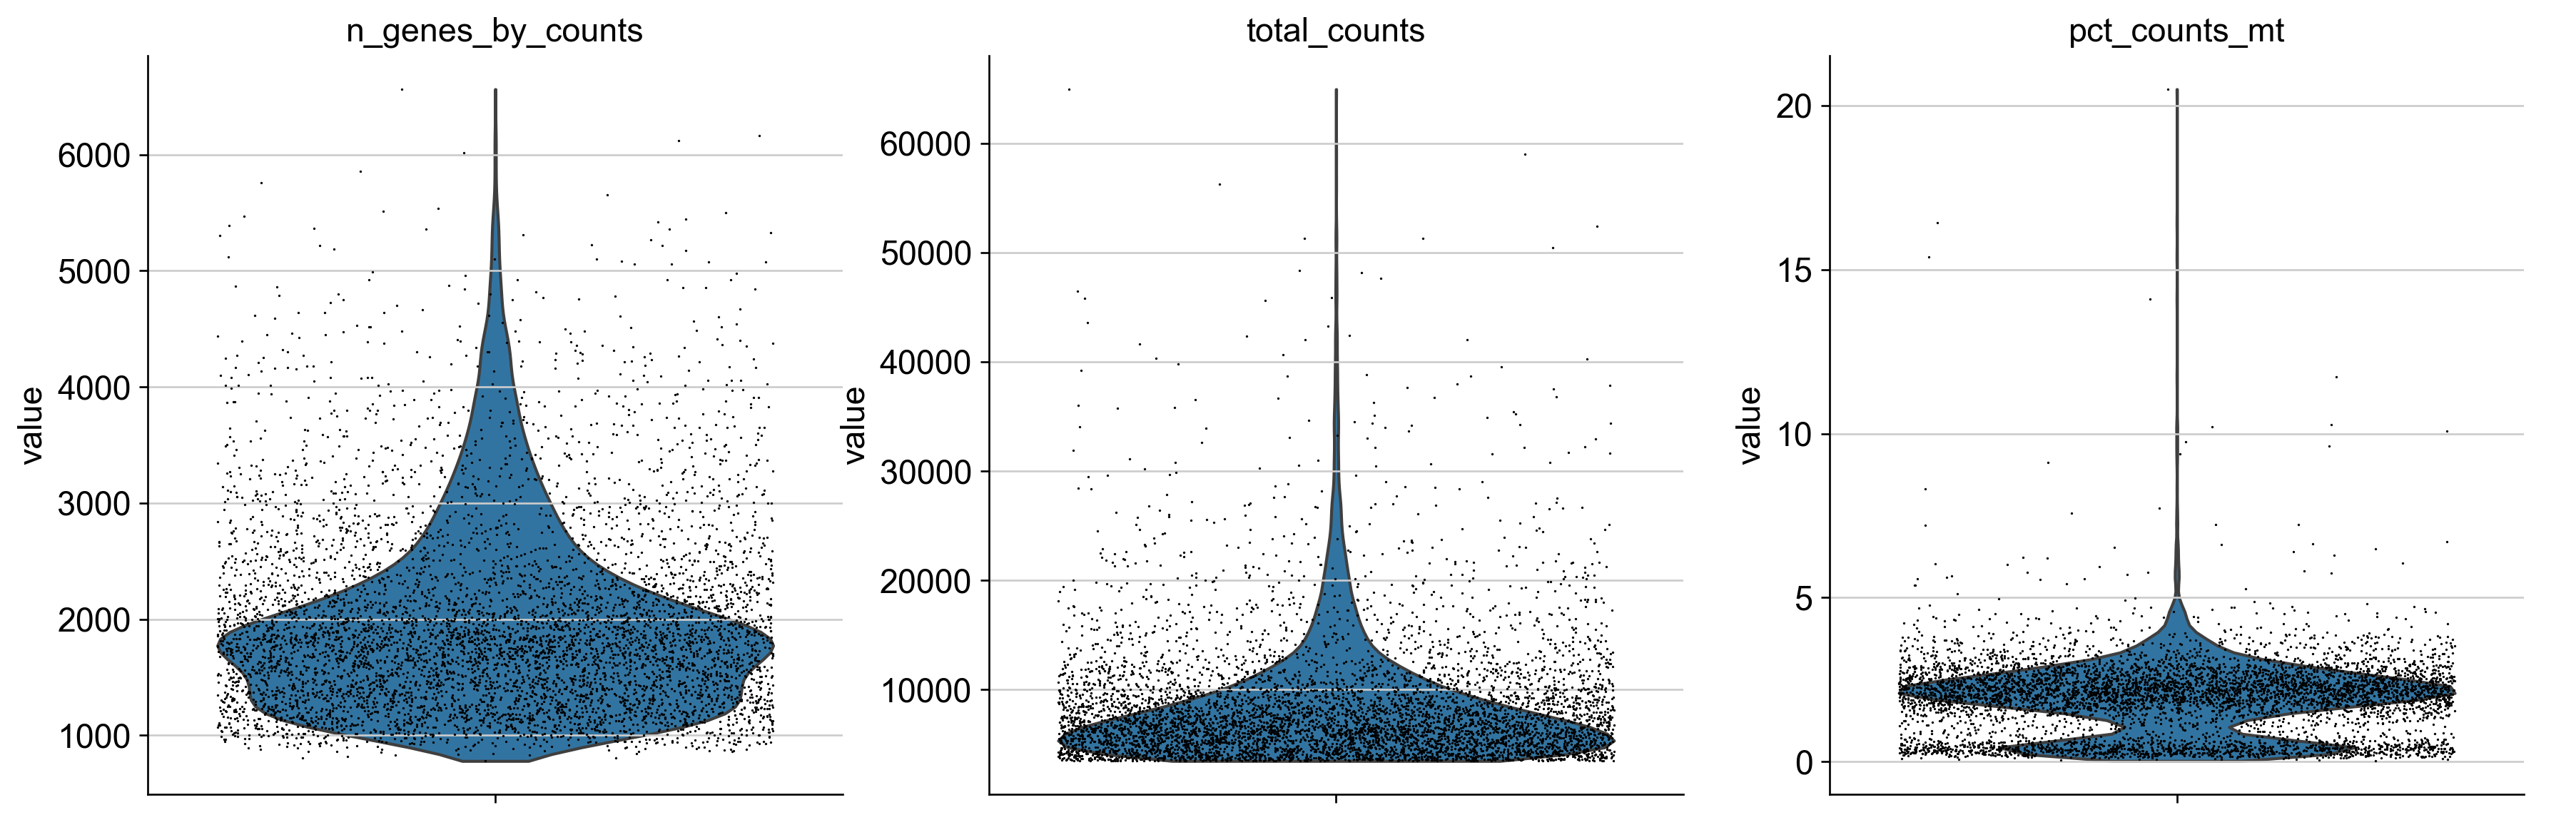

In [103]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
    save="_qc_before.png"
)

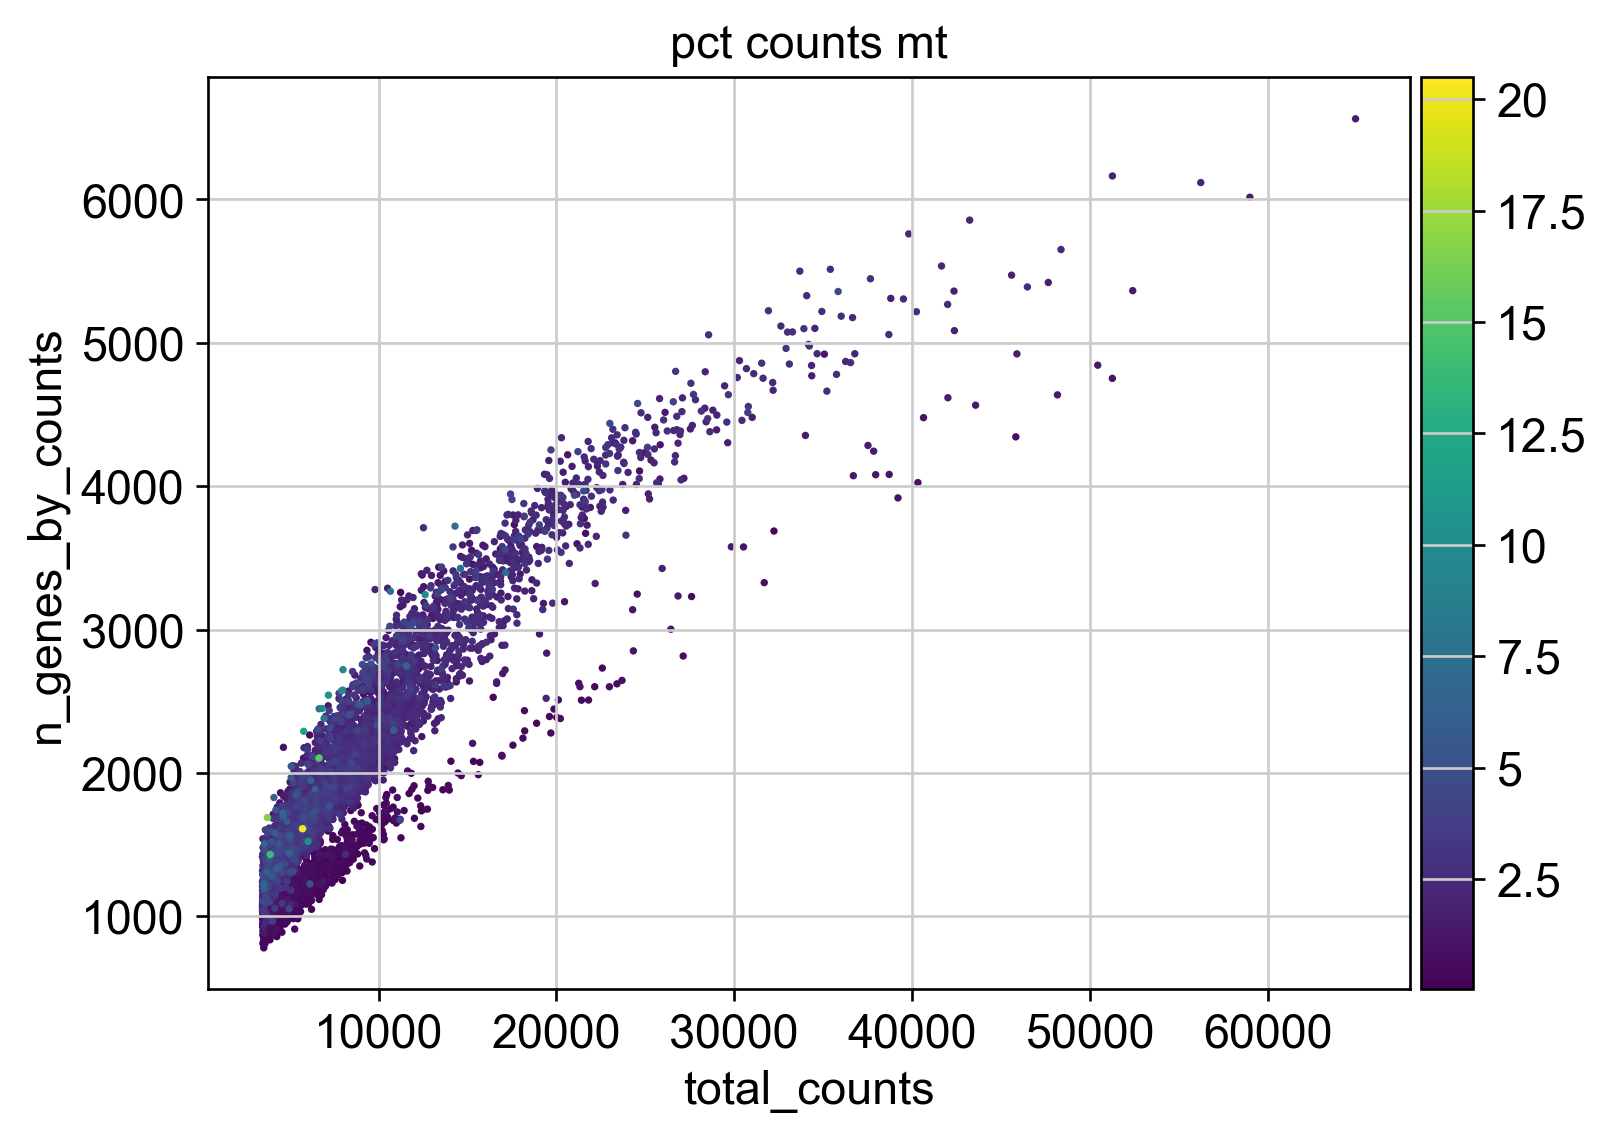

In [104]:
sc.pl.scatter(
    adata,
    x="total_counts",
    y="n_genes_by_counts",
    color="pct_counts_mt",
    save="_qc_scatter_before.png"
)


## Filtrado del dataset 

El conjunto de datos debe ser filtrado para que el análisis posterior sea valioso para la investigación. Deben ser eliminados los genes que a penas son detectados (umbral mínimo de 3 conteos). Se deberían filtrar las células aplicando un corte donde tengan cada una al menos 200 genes en su conteo, sin embargo, dado al mínimo de 779 genes, no es necesario hacer este corte. En cuanto al porcentaje de contenido mitocondrial dado los valores bastante bajos en el dataset (a excepción de algunos outliers con un 20%) se podría bajar a un máximo de 5%, siendo así estricto con el estrés/células dañadas.

In [105]:
# Genes expresados en pocas células
sc.pp.filter_genes(adata, min_cells=3)

# Células con pocos genes detectados
#adata = adata[adata.obs["n_genes_by_counts"] > 200, :].copy()

# Células con alto % mitocondrial
adata = adata[adata.obs["pct_counts_mt"] < 5, :].copy()

print("Después de QC, células:", adata.n_obs, "genes:", adata.n_vars)

filtered out 13545 genes that are detected in less than 3 cells
Después de QC, células: 6030 genes: 14453


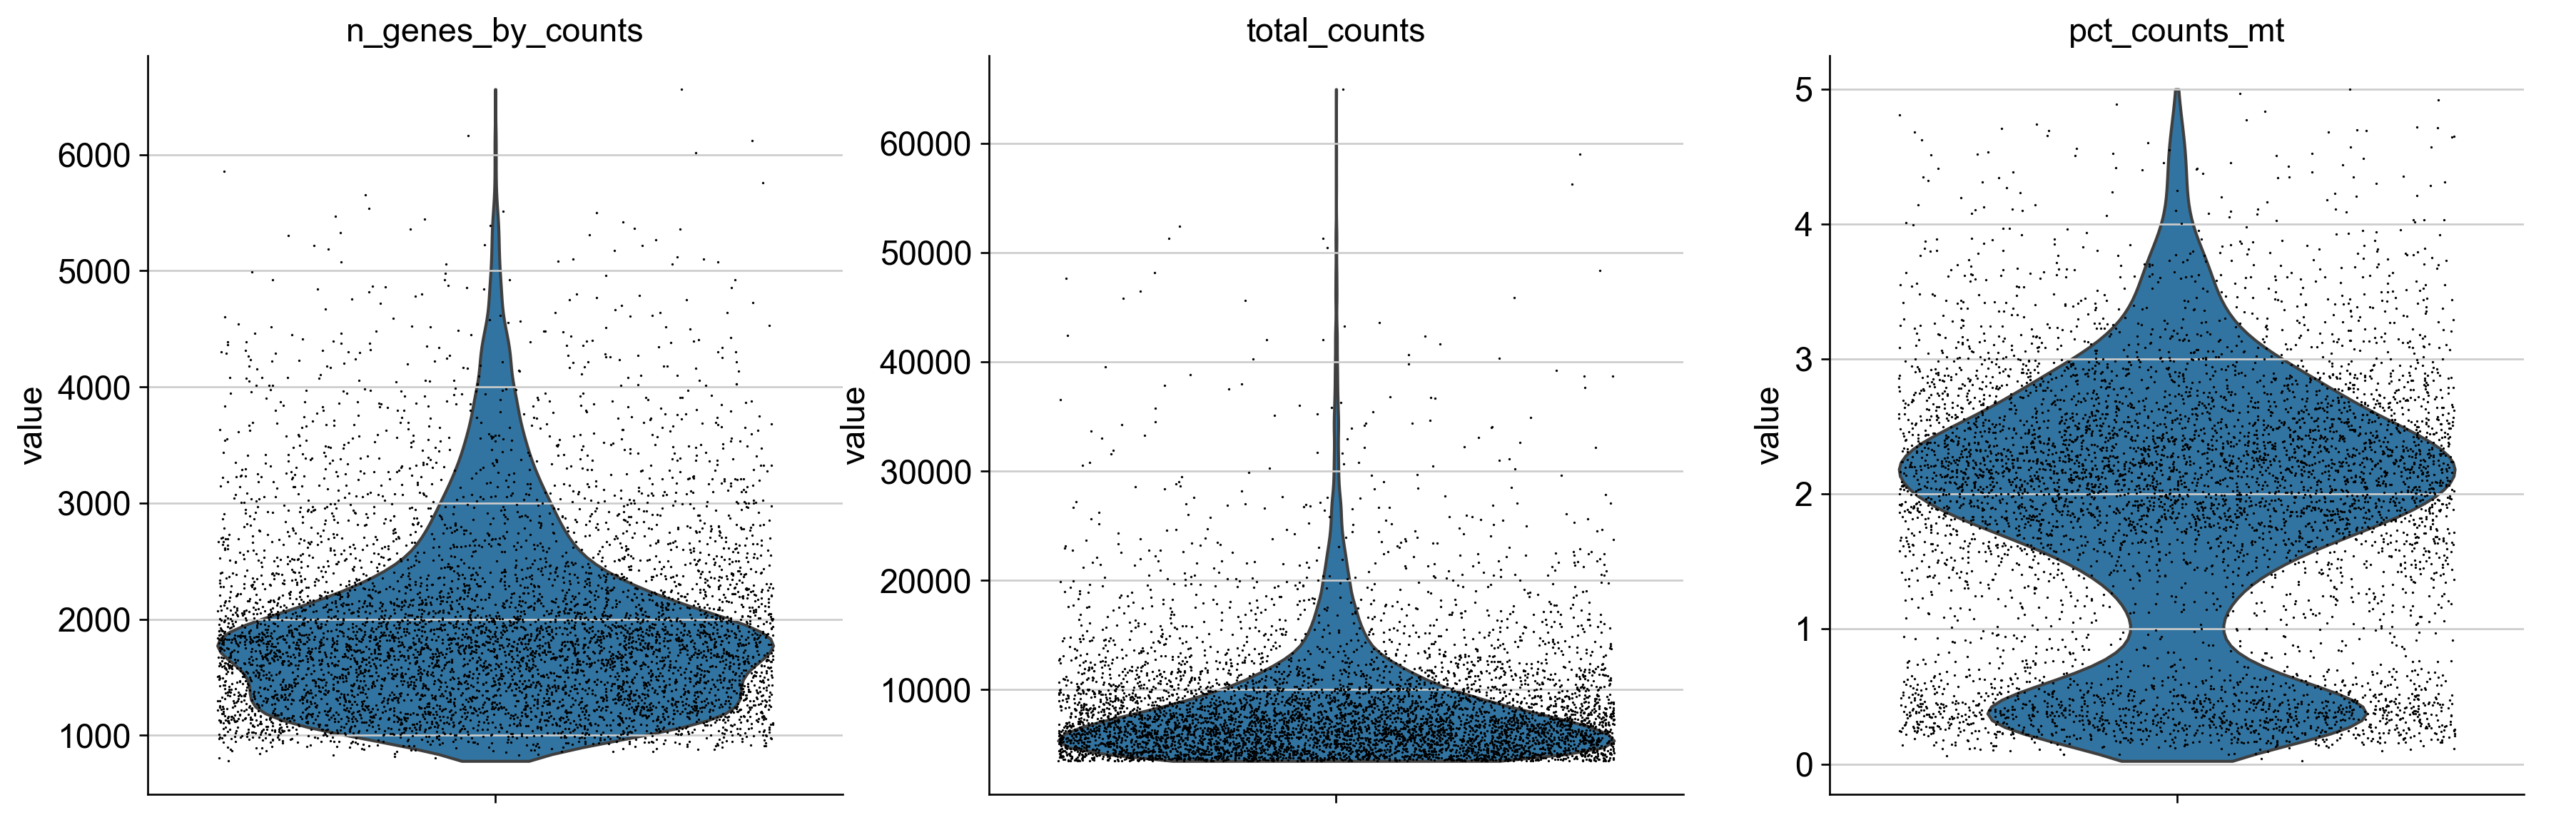

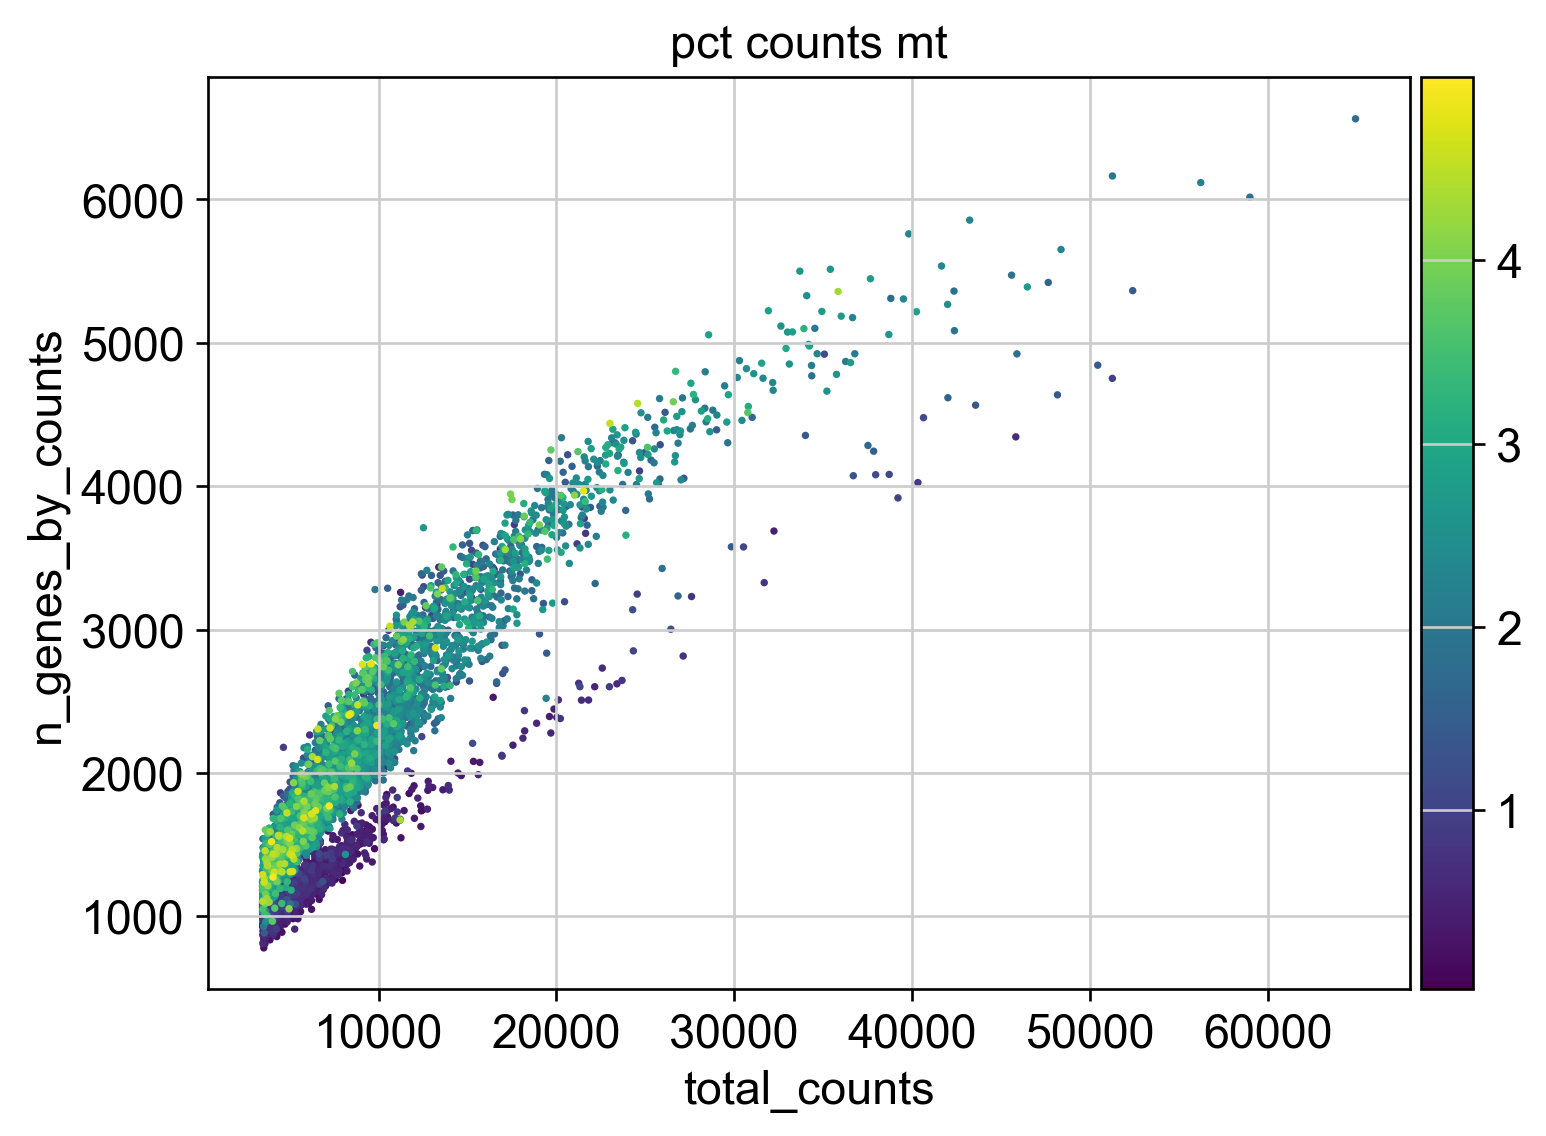

In [106]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
    save="_qc_after.png"
)

sc.pl.scatter(
    adata,
    x="total_counts",
    y="n_genes_by_counts",
    color="pct_counts_mt",
    save="_qc_scatter_after.png"
)


El gráfico de violín de genes detectados por células luego del filtrado, no muestra grandes cambios. Ya que se eliminaron células con menos de 1000 genes contados, las cuales probablemente eran células muertas o débiles. Esto es concordante con la cantidad de genes que se eliminaron (13 545) que se detectaron en menos de tres células cada uno. 

En el segundo gráfico, se observa una concentración de las células por debajo de 10000, pero algunas alcanzan valores muy elevados. Esto puede deberse a la existencia de dobletes o células que "almacenan" contenido de otras. 

En el tercer gráfico, las células que se encuentran entre 0 y 1, son células muy sanas y con alta integridad citoplasmática, mientras que la segunda concentración, entre 2 y 3, representan células con un nivel bajo o moderado de contenido mitocondrial. 

El 4to gráfico revela la relación entre cantidad de datos (lecturas), diversidad génica y calidad celular (mitocondrial). Las células en la zona central con colores verdes/azules son las ideales para análisis; las de la esquina superior derecha (amarillas) deben considerarse para descarte por alta contaminación mitocondrial. Luego del filtrado mejoran considerablemente los datos.

In [107]:
# Normalización por célula (target_sum=1e4 es estándar) para aplicar el metodo posterior de reduccion de dimensionaldiad
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata) # Transformación log

normalizing counts per cell
    finished (0:00:00)


In [108]:
# Guardar copia normalizada completa para referencia
adata.raw = adata.copy()  # preserva matriz normalizada/log en adata.raw


## Genes variables y reducción de dimensionalidad

Quedarse con los genes que varían entre células reduce la dimensionalidad, y permite quedarnos con genes informativos para distinguir tipos celulares y enfermedades.

Queremos que los genes no estén casi siempre apagandos, no sean muy abundantes en las células y se muestren variaciones informativas entre cada célula. Buscar un subconjunto manejable de genes que capturen eficientemente la heterogeneidad biológica entre las células. 

In [109]:
sc.pp.highly_variable_genes(
    adata,
    min_mean=0.0125, # filtrar expresiones medias muy bajas
    max_mean=3, # filtrar expresiones media muy altas
    min_disp=0.5 # mímina variablidad admitida
)

print(adata.var["highly_variable"].sum(), "genes altamente variables")

# Subconjunto a HVGs
# Guardar lista HVGs
hvg_df = adata.var[adata.var["highly_variable"]].copy()
hvg_df.to_csv(os.path.join(OUTPUT_DIR, "highly_variable_genes.csv"))


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
1498 genes altamente variables


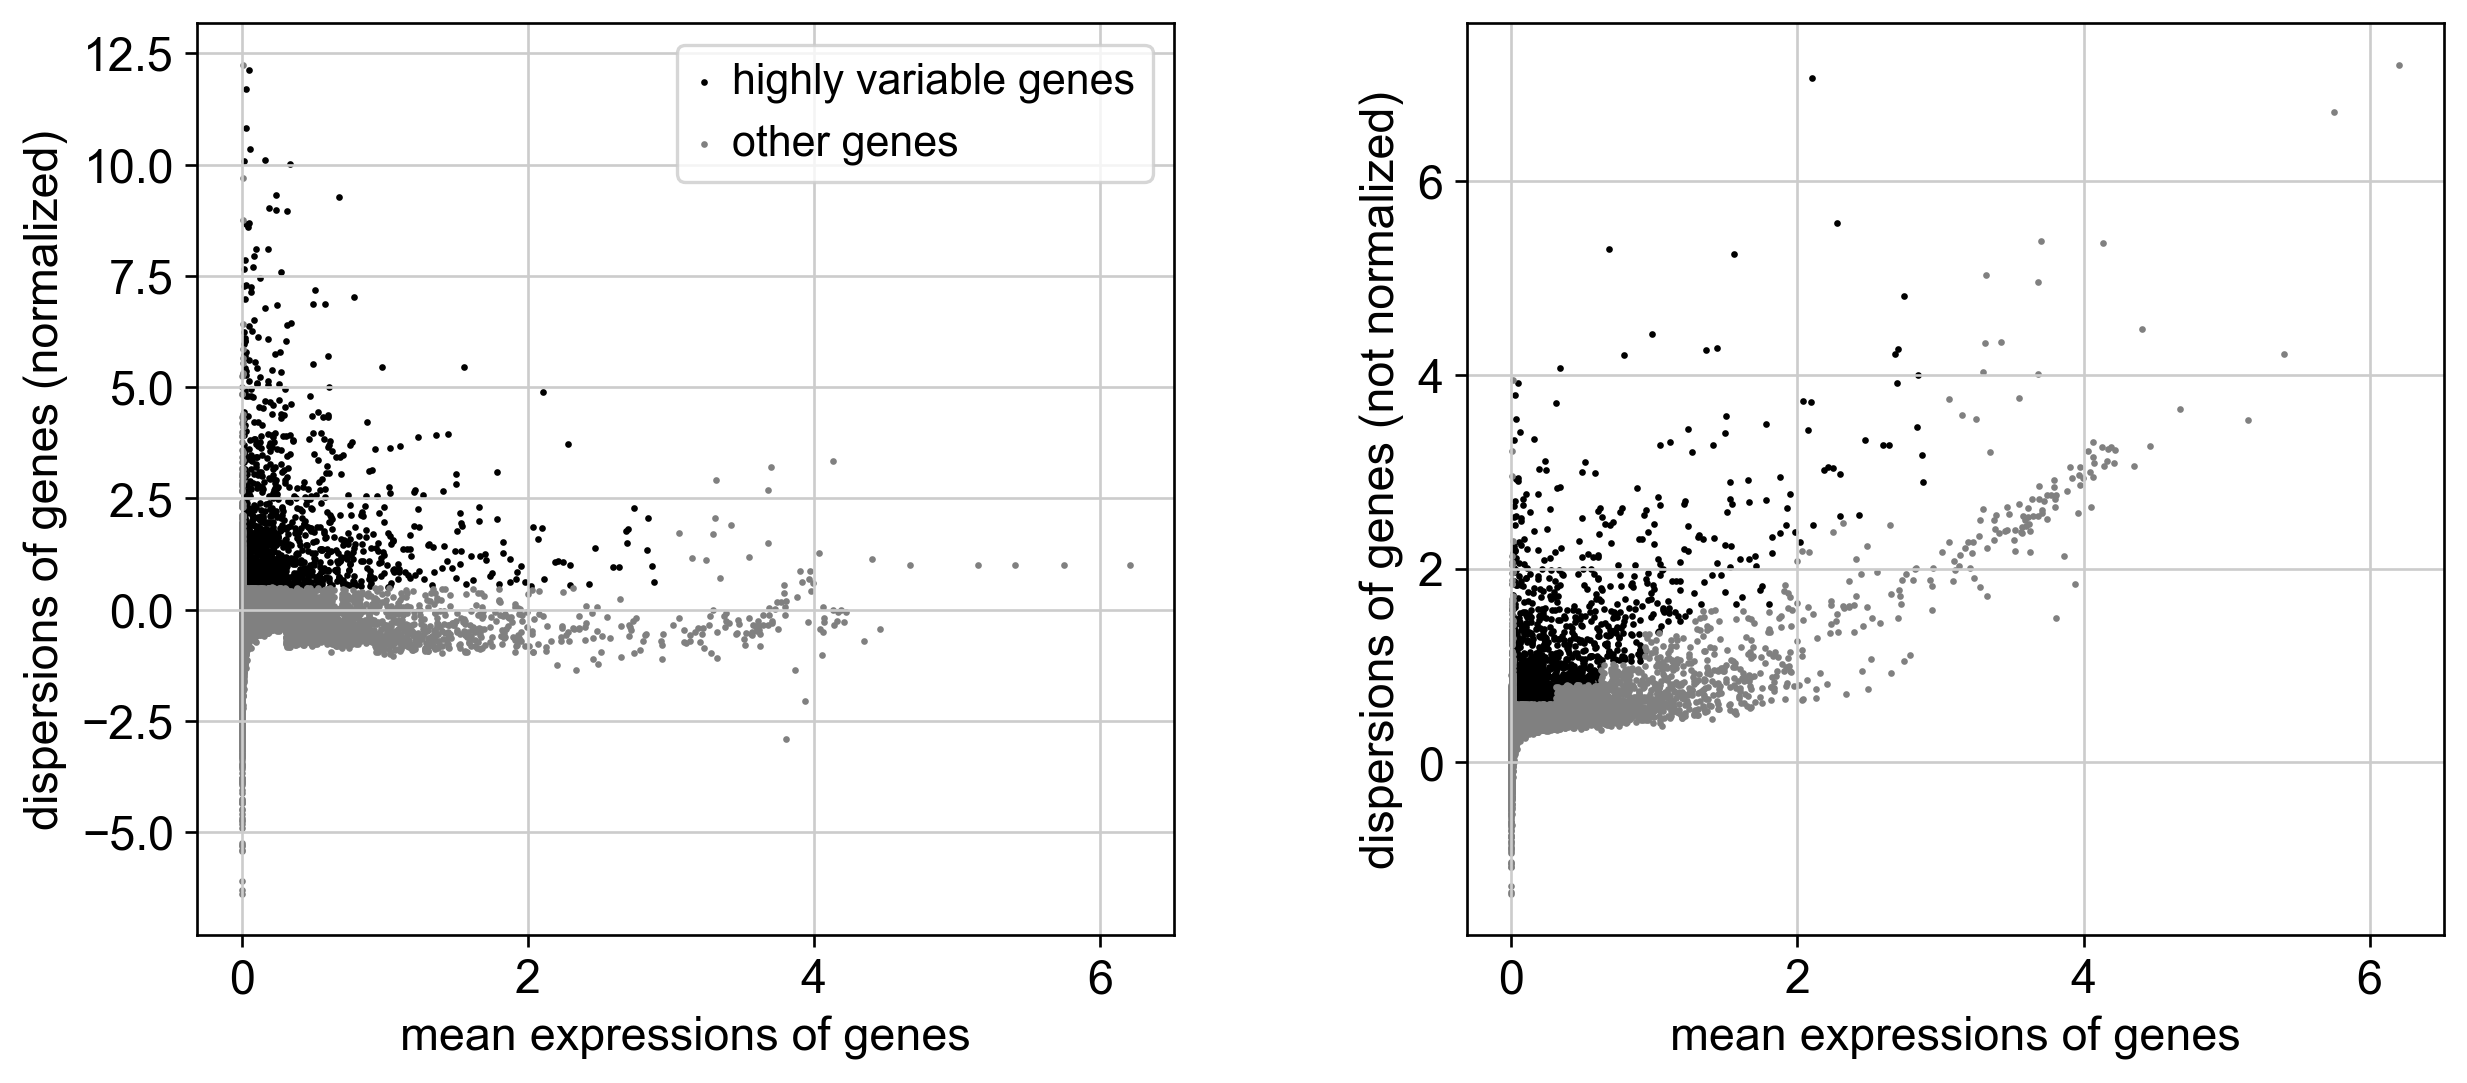

In [110]:
# Visualizar HVGs
sc.pl.highly_variable_genes(adata, save="_highly_variable_genes.png")

In [111]:
# Subconjunto para análisis (HVGs) 
adata = adata[:, adata.var["highly_variable"]].copy()
print(f"Objeto HVG: {adata.n_obs} células × {adata.n_vars} genes")

Objeto HVG: 6030 células × 1498 genes


Luego de tener clara la variabilidad debe escalarse para que se puedan realizar comparaciones.

In [112]:
sc.pp.scale(adata, max_value=10) # escalar media 0 y varianza 1, con un valor máximo de 10 en std (recorte)

sc.tl.pca(adata, n_comps=50, svd_solver="arpack") #50 componentes principales
print(adata.uns["pca"]["variance_ratio"][:10]) 

computing PCA
    with n_comps=50
    finished (0:00:00)
[0.09250934 0.05655673 0.03007306 0.02098684 0.01471787 0.00906784
 0.00823792 0.00798315 0.0063974  0.00510936]


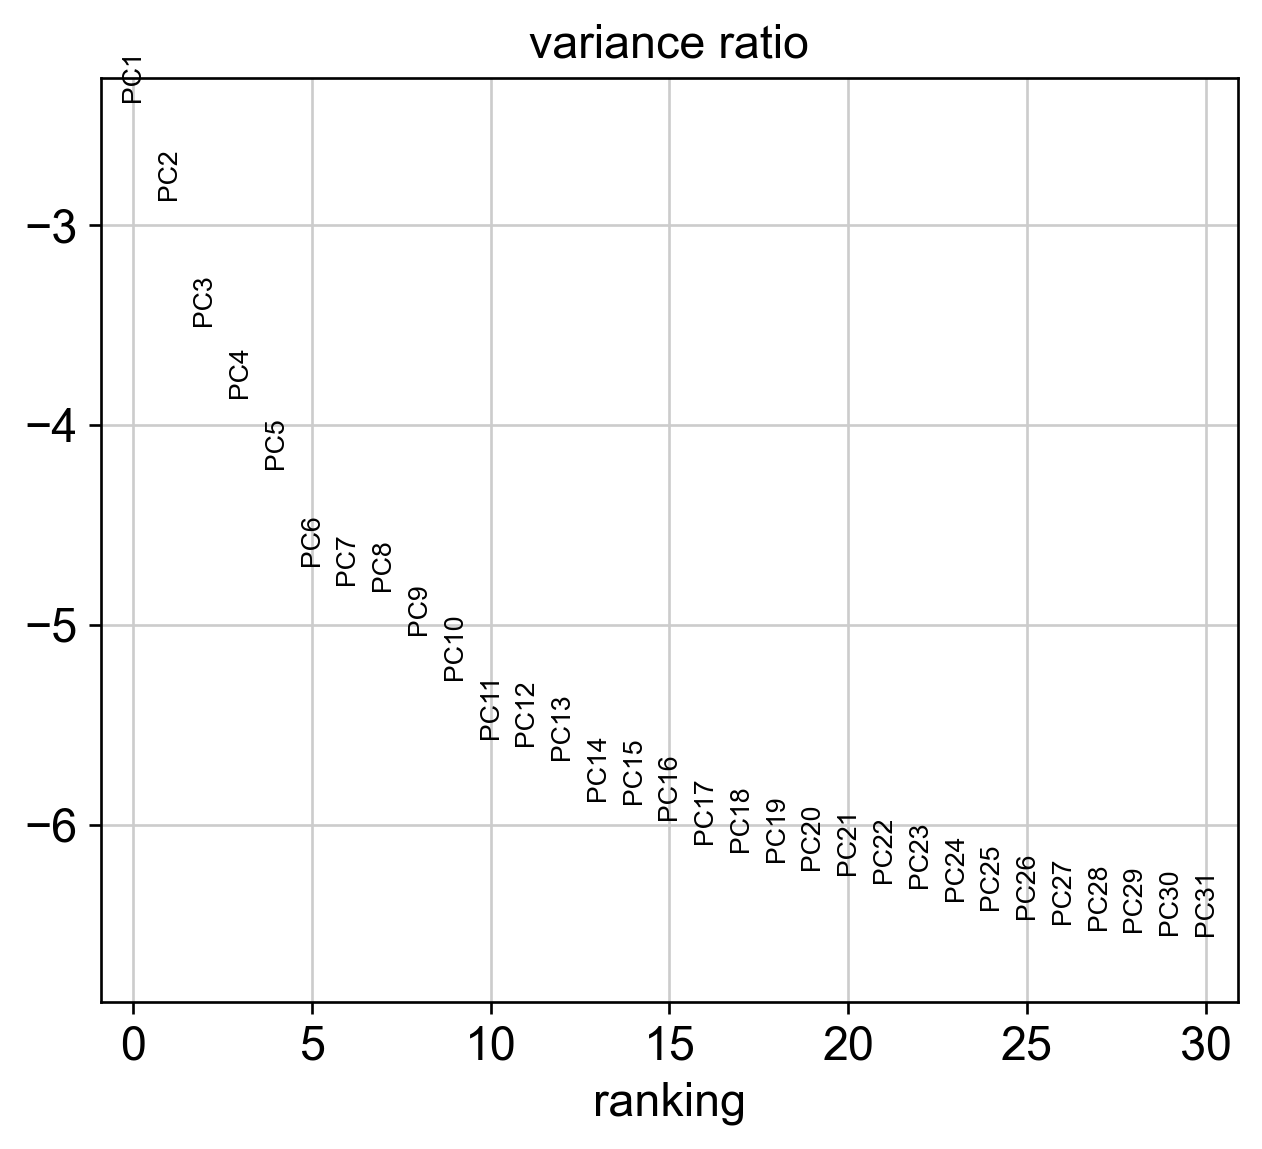

In [113]:
sc.pl.pca_variance_ratio(adata, n_pcs=30, log=True, save="_pca_variance.png")

Las primeras PC explican la mayor fracción de la varianza biológica entre células , de modo que capturan los ejes dominantes de heterogeneidad celular. Las PC de orden superior tienden a reflejar variación de menor magnitud , a menudo asociada a subestados más finos, gradientes continuos o incluso ruido técnico. Las PC definen un espacio latente de baja dimensionalidad donde cada célula se posiciona según el grado de activación de esos programas transcriptómicos. 

## Agrupamiento

Una vez realizado el PCA que reduce la información de los genes en pocas dimensiones se facilita el agrupamiento y aplicación de UMAP. Este último consiste en proyecciones 2D de la estructura global de los datos. Por otro lado, Leiden agrupa las células con perfiles de expresión parecidos en los clusteres que se establecen.

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:14)
running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


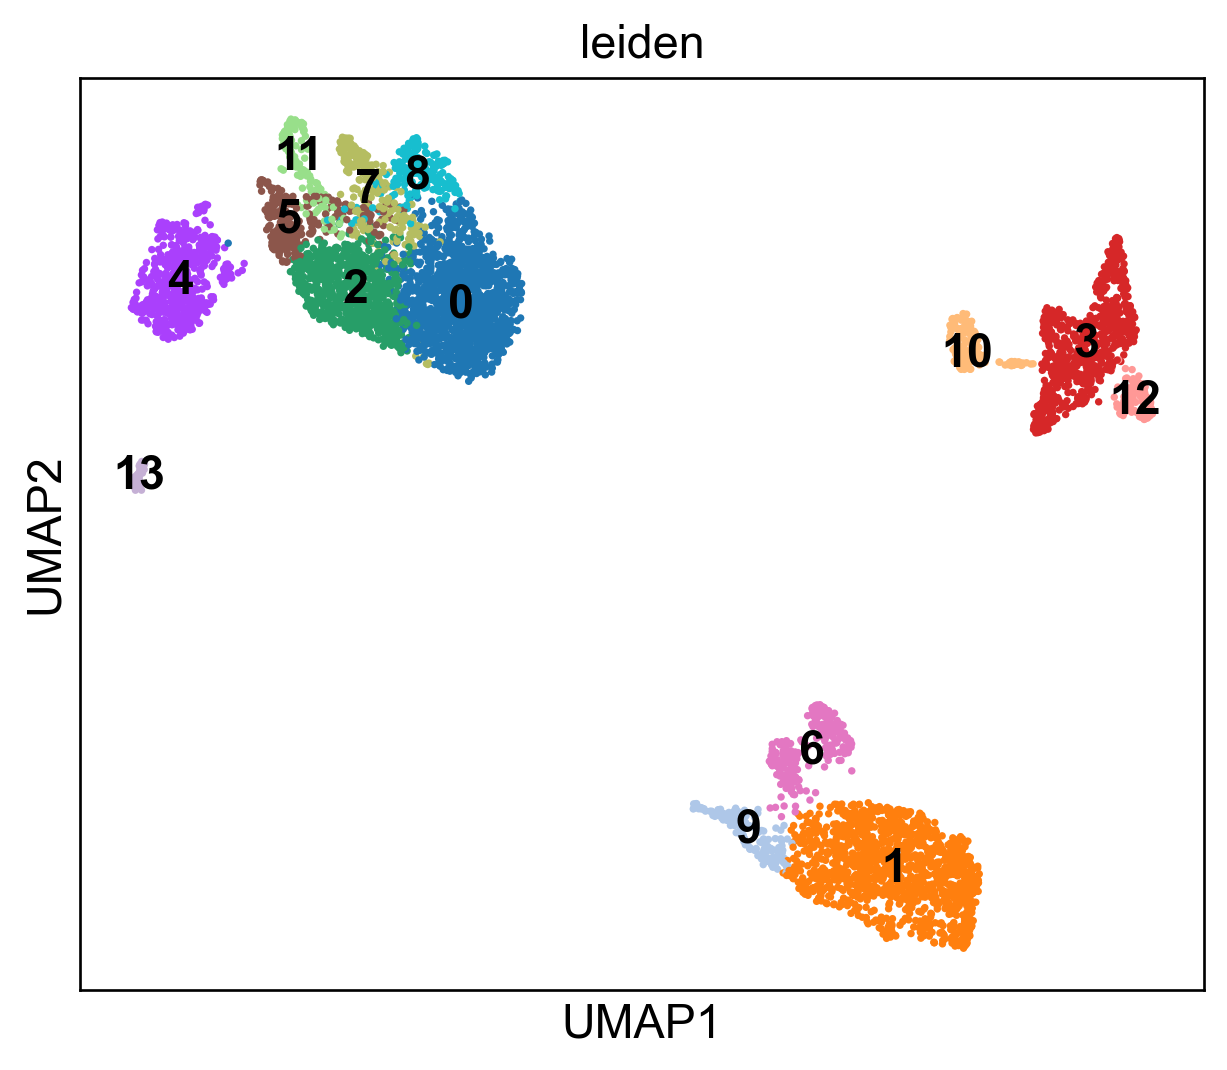

In [114]:
# Vecinos y UMAP
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)
sc.tl.umap(adata)

resolution = 0.5
# Clustering Leiden
sc.tl.leiden(adata, resolution=resolution)
# Visualizar clusters
sc.pl.umap(adata, color=["leiden"], legend_loc="on data", save=f"_umap_leiden_r{resolution}.png")

Cada cluster representa una subpoblación celular con un programa de expresión característico: algunos clusters serán tipos celulares claramente distintos  y otros pueden corresponder a estados funcionales o de activación dentro de un mismo tipo celular. El hecho de que los clusters estén bien separados espacialmente indica que las diferencias transcriptómicas entre esas poblaciones son marcadas. 

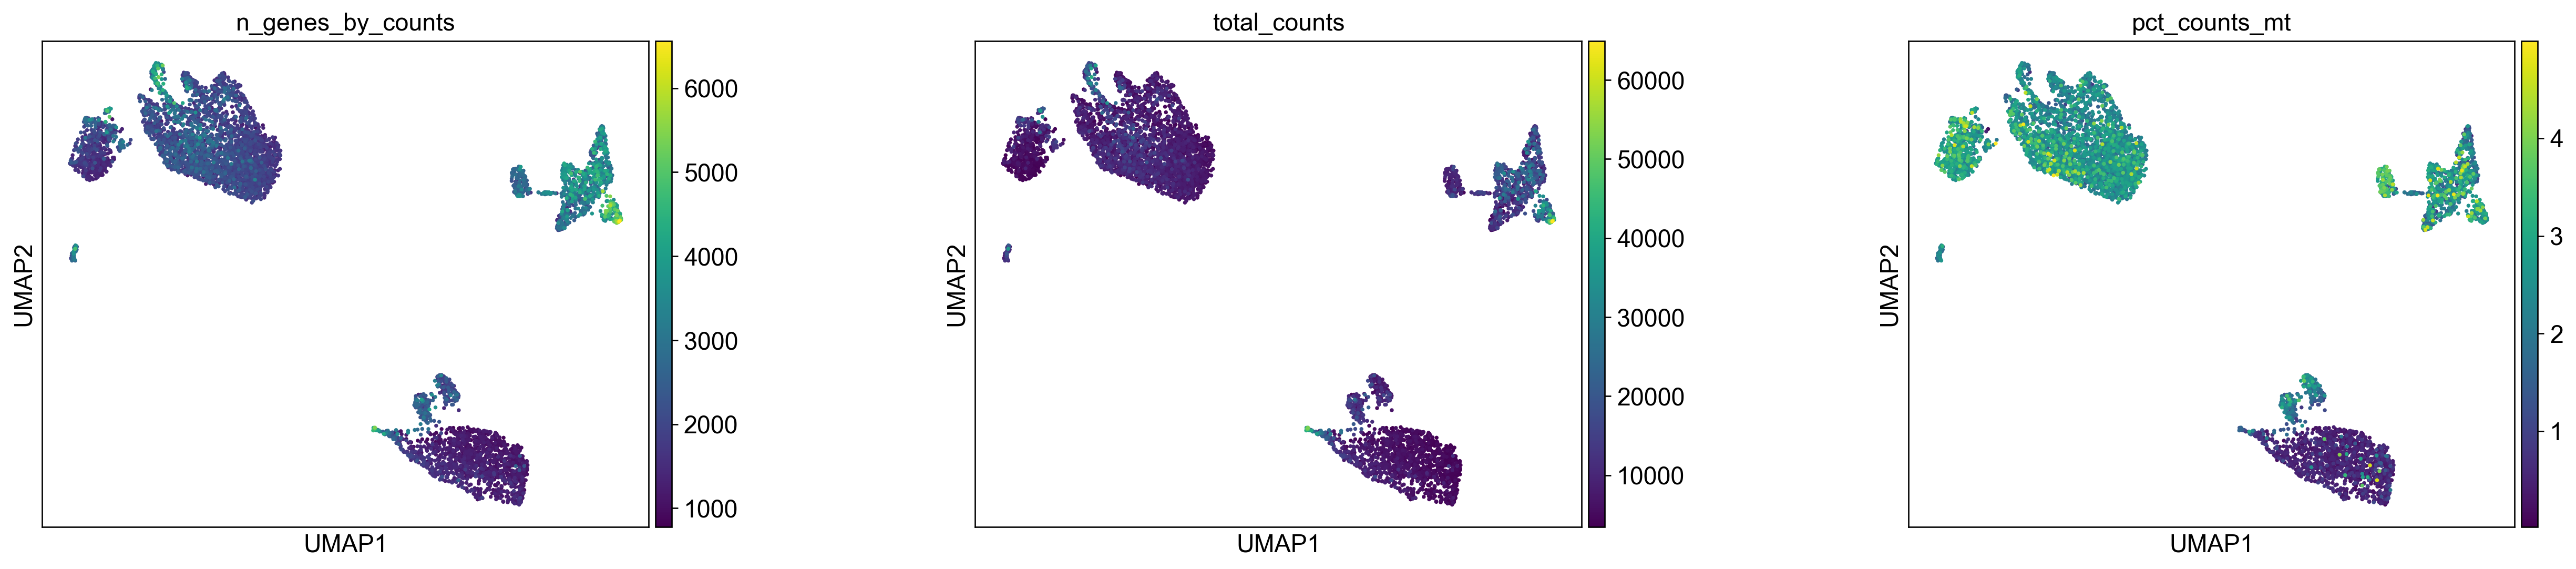

In [115]:
sc.pl.umap(
    adata,
    color=["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    wspace=0.4, save="_umap_qc_metrics.png"
)

Por clusters podemos ver cuáles genes están más enriquecidos (marcadores).

## Aplicación de marcadores

Al visualizar los clusters donde se expresan los genes marcadores definidos se pueden asignar tipos celulares al cluster según la firma más presente.

In [116]:

# Comprobar qué marcadores de tu lista están presentes
marker_genes = [
    "S100a8", "S100a9", "Mmp9", "Csf3r", "Fcgr3", "Bst1",
    "Siglech", "Irf8", "Flt3",
    "Cd3d", "Cd3e", "Il2rb", "Cd4", "Cd8a", "Cd8b1",
    "Ms4a1", "Cd79a", "Cd79b", "Cd19",
    "Ccl9", "Csf1r", "S100a4", "Fcgr3",
]

present = [g for g in marker_genes if g in adata.var_names]
missing = [g for g in marker_genes if g not in adata.var_names]

print("Presentes:", present)
print("Ausentes:", missing)


Presentes: ['Mmp9', 'Csf3r', 'Fcgr3', 'Bst1', 'Siglech', 'Irf8', 'Flt3', 'Il2rb', 'Cd4', 'Cd8a', 'Cd8b1', 'Ms4a1', 'Cd79a', 'Cd79b', 'Cd19', 'Ccl9', 'Csf1r', 'S100a4', 'Fcgr3']
Ausentes: ['S100a8', 'S100a9', 'Cd3d', 'Cd3e']


['Mmp9', 'Csf3r', 'Fcgr3', 'Bst1', 'Siglech', 'Irf8', 'Flt3', 'Il2rb', 'Cd4', 'Cd8a', 'Cd8b1', 'Ms4a1', 'Cd79a', 'Cd79b', 'Cd19', 'Ccl9', 'Csf1r', 'S100a4']


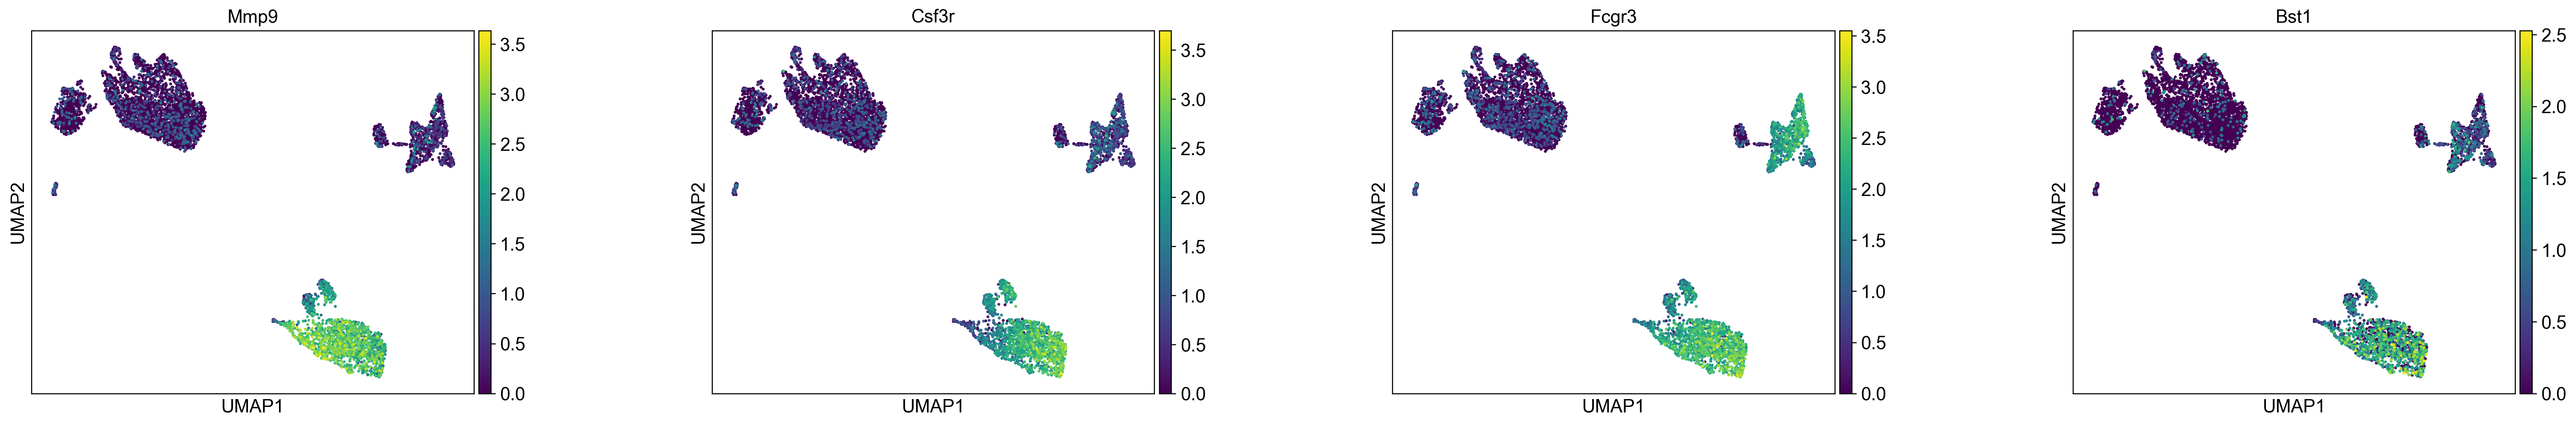

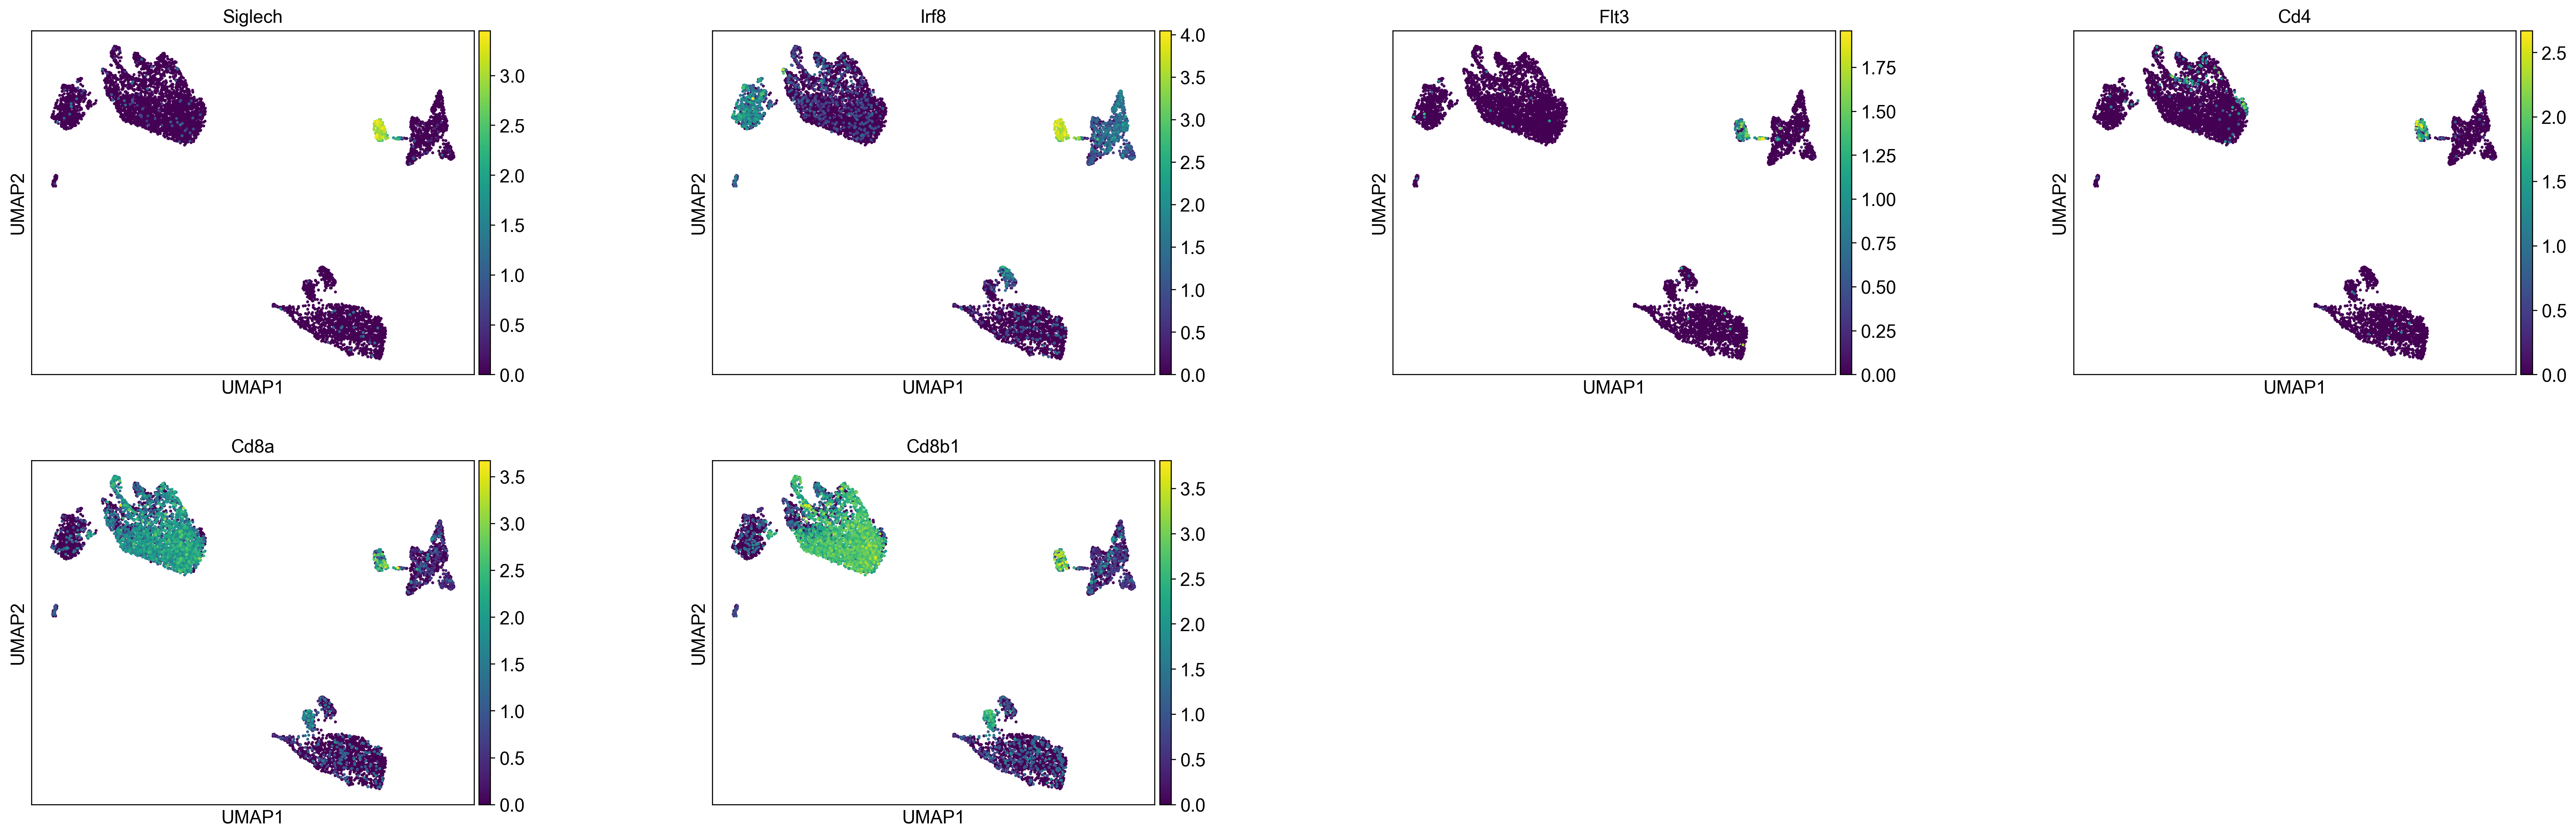

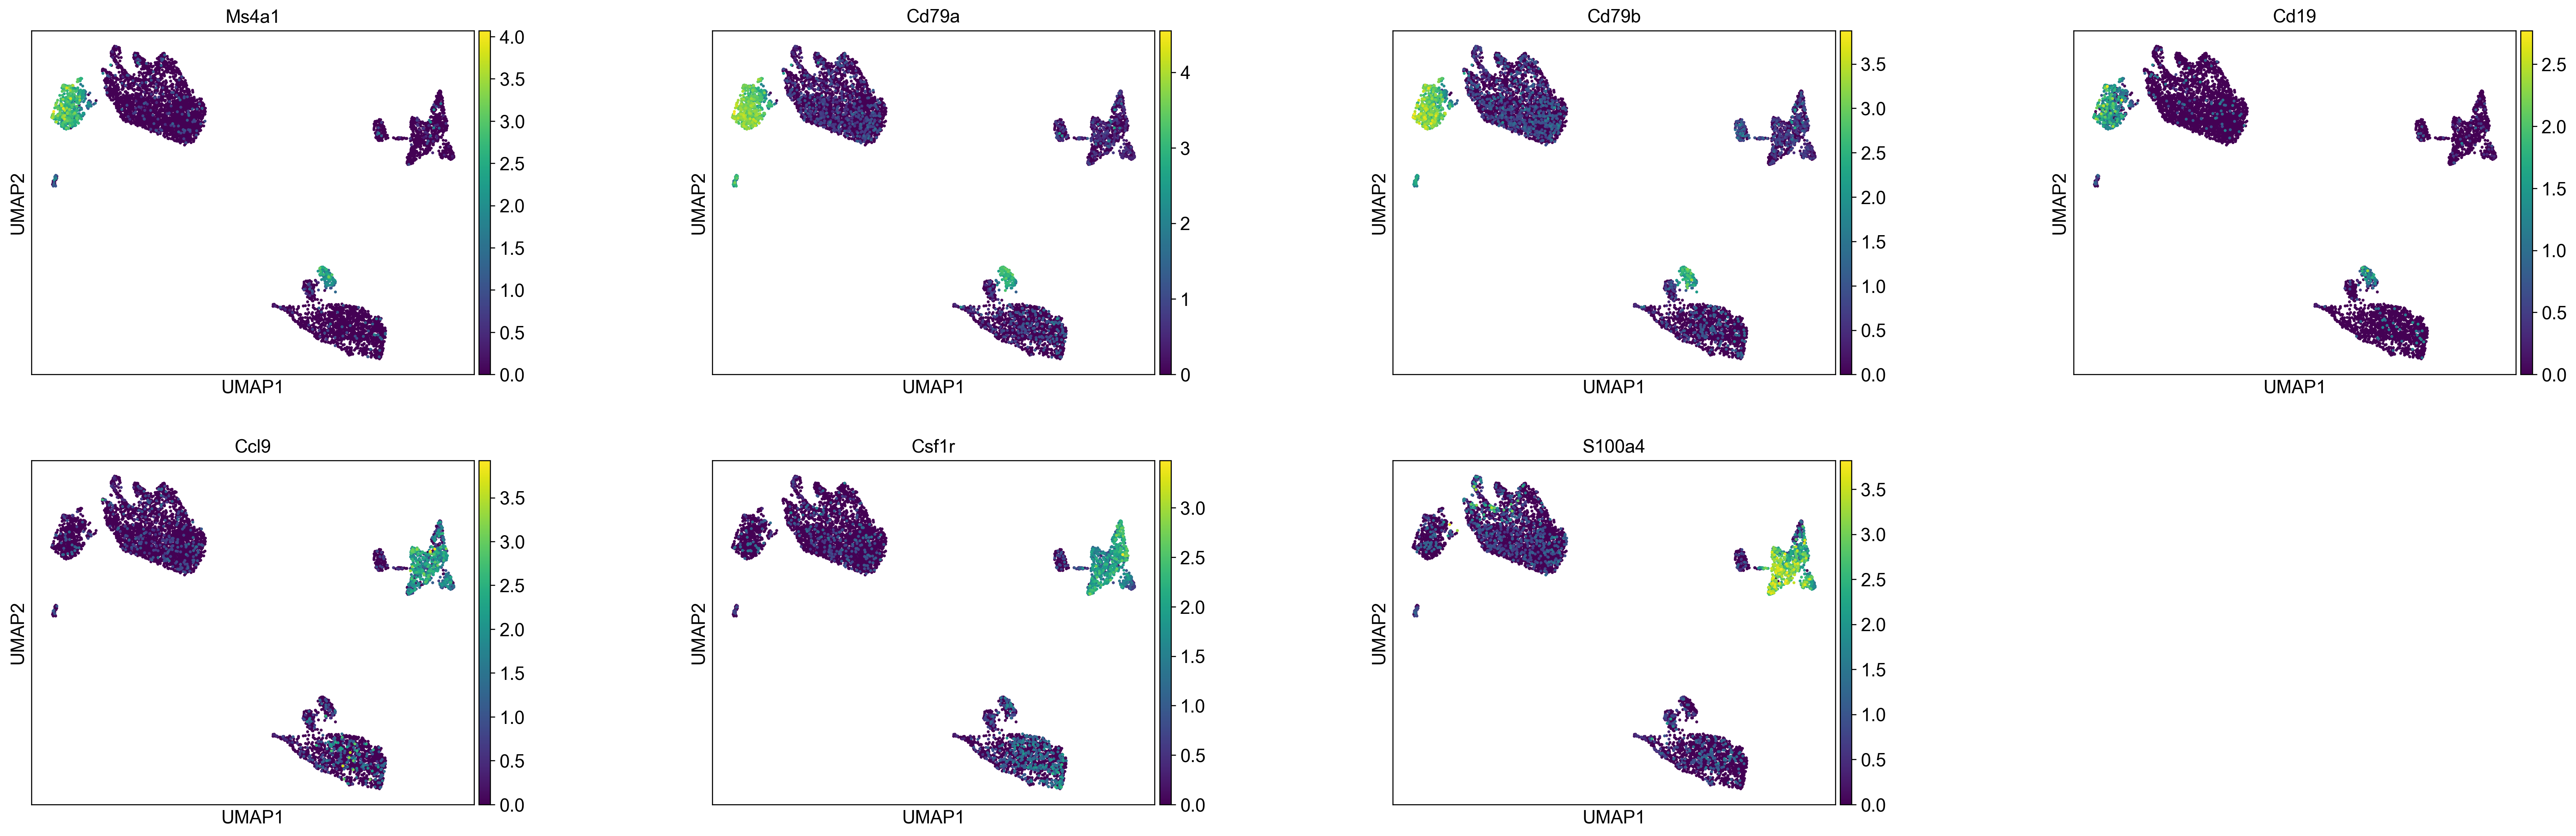

In [117]:
marker_genes = [
    "Mmp9", "Csf3r", "Fcgr3", "Bst1",        # Neutrófilos
    "Siglech", "Irf8", "Flt3",                                  # Dendríticas
    "Il2rb", "Cd4", "Cd8a", "Cd8b1",            # T (CD4/CD8)
    "Ms4a1", "Cd79a", "Cd79b", "Cd19",                          # B
    "Ccl9", "Csf1r", "S100a4",                                  # Monocitos / mieloides
]

# Ver qué genes existen realmente en el dataset
print([g for g in marker_genes if g in adata.var_names])

# UMAP coloreado por cada marcador (hazlo en dos tandas si son muchos)
sc.pl.umap(adata, color=["Mmp9", "Csf3r", "Fcgr3", "Bst1"], wspace=0.4)
sc.pl.umap(adata, color=["Siglech", "Irf8", "Flt3", "Cd4", "Cd8a", "Cd8b1"], wspace=0.4)
sc.pl.umap(adata, color=["Ms4a1", "Cd79a", "Cd79b", "Cd19", "Ccl9", "Csf1r", "S100a4"], wspace=0.4)


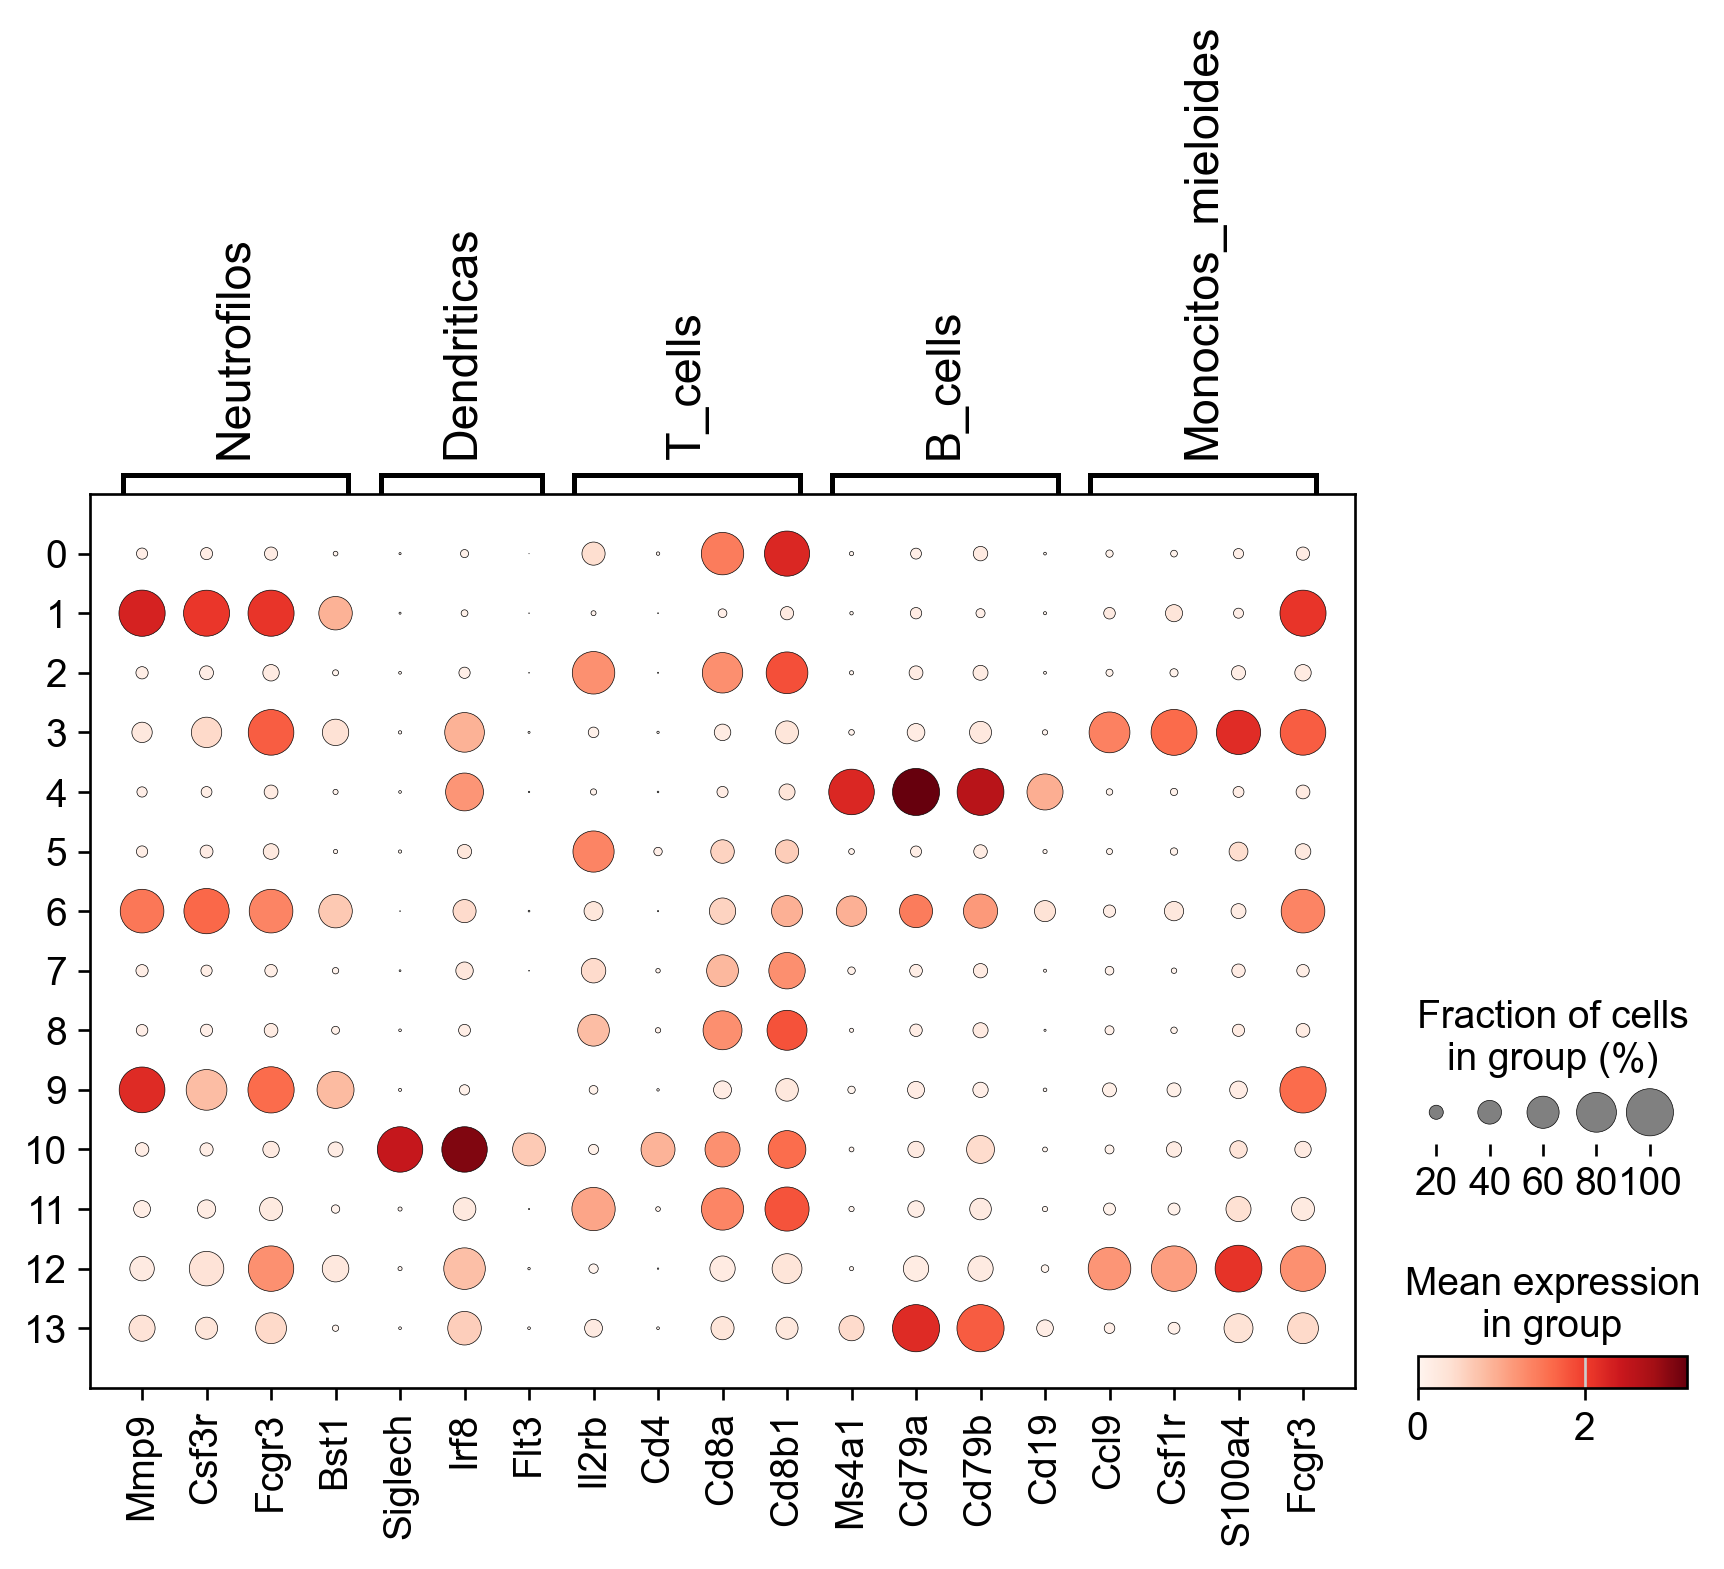

In [118]:
sc.pl.dotplot(
    adata,
    var_names={
        "Neutrofilos": ["Mmp9", "Csf3r", "Fcgr3", "Bst1"],
        "Dendriticas": ["Siglech", "Irf8", "Flt3"],
        "T_cells": ["Il2rb", "Cd4", "Cd8a", "Cd8b1"],
        "B_cells": ["Ms4a1", "Cd79a", "Cd79b", "Cd19"],
        "Monocitos_mieloides": ["Ccl9", "Csf1r", "S100a4", "Fcgr3"],
    },
    groupby="leiden",
    save="marcadores_definidos.png"
)
# tamaño y color indican el porcentaje de células del cluster que expresan el gen, y cuánto

## Búsqueda de marcadores (no predefinido)

Para la búsqueda de marcadores (gen se expresa significativamente distinto en un grupo de células) mediante la comparación entre grupos. Puede ser mejor que la prueba t ya que los datos no son normales, hay una gran variabilidad y se tienen en cuenta sesgos. 

In [ ]:
# Calcular genes marcadores por clúster (uno contra todos)
sc.tl.rank_genes_groups(
    adata,
    groupby="leiden",           
    method="wilcoxon",          # robusto y rápido; también "t-test", "logreg"
    n_genes=10                  # número de marcadores a considerar por grupo
)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:16)


In [ ]:
# Extraer los top genes marcadores
cluster_markers = {}
for cluster in adata.obs["leiden"].cat.categories:
    top_genes = sc.get.rank_genes_groups_df(adata, group=cluster).head(3)["names"].tolist()
    cluster_markers[cluster] = top_genes

# aplanar para visualización
all_marker_genes = list(set(g for genes in cluster_markers.values() for g in genes))

In [122]:
# 👇 IMPRIMIR los marcadores por clúster (legible)
print("=== MARCADORES IDENTIFICADOS POR CLÚSTER ===")
for cluster, genes in cluster_markers.items():
    print(f"Clúster {cluster}: {', '.join(genes)}")


=== MARCADORES IDENTIFICADOS POR CLÚSTER ===
Clúster 0: Tpt1, Rps27, Rps29
Clúster 1: S100a11, Wfdc17, Alox5ap
Clúster 2: Ccl5, Nkg7, Il2rb
Clúster 3: Ctss, Ms4a6c, Psap
Clúster 4: Cd79a, Cd74, Cd79b
Clúster 5: Ccl5, AW112010, Nkg7
Clúster 6: Il1b, Csf3r, Cxcr2
Clúster 7: Slamf6, Smc4, Sh2d1a
Clúster 8: Isg15, Ifit3, Ifit1
Clúster 9: Ngp, Lcn2, Cd177
Clúster 10: Bst2, Tcf4, Rnase6
Clúster 11: Stmn1, Ptma, H2afz
Clúster 12: H2afz, 2810417H13Rik, Tuba1b
Clúster 13: Ssr4, Jchain, Xbp1


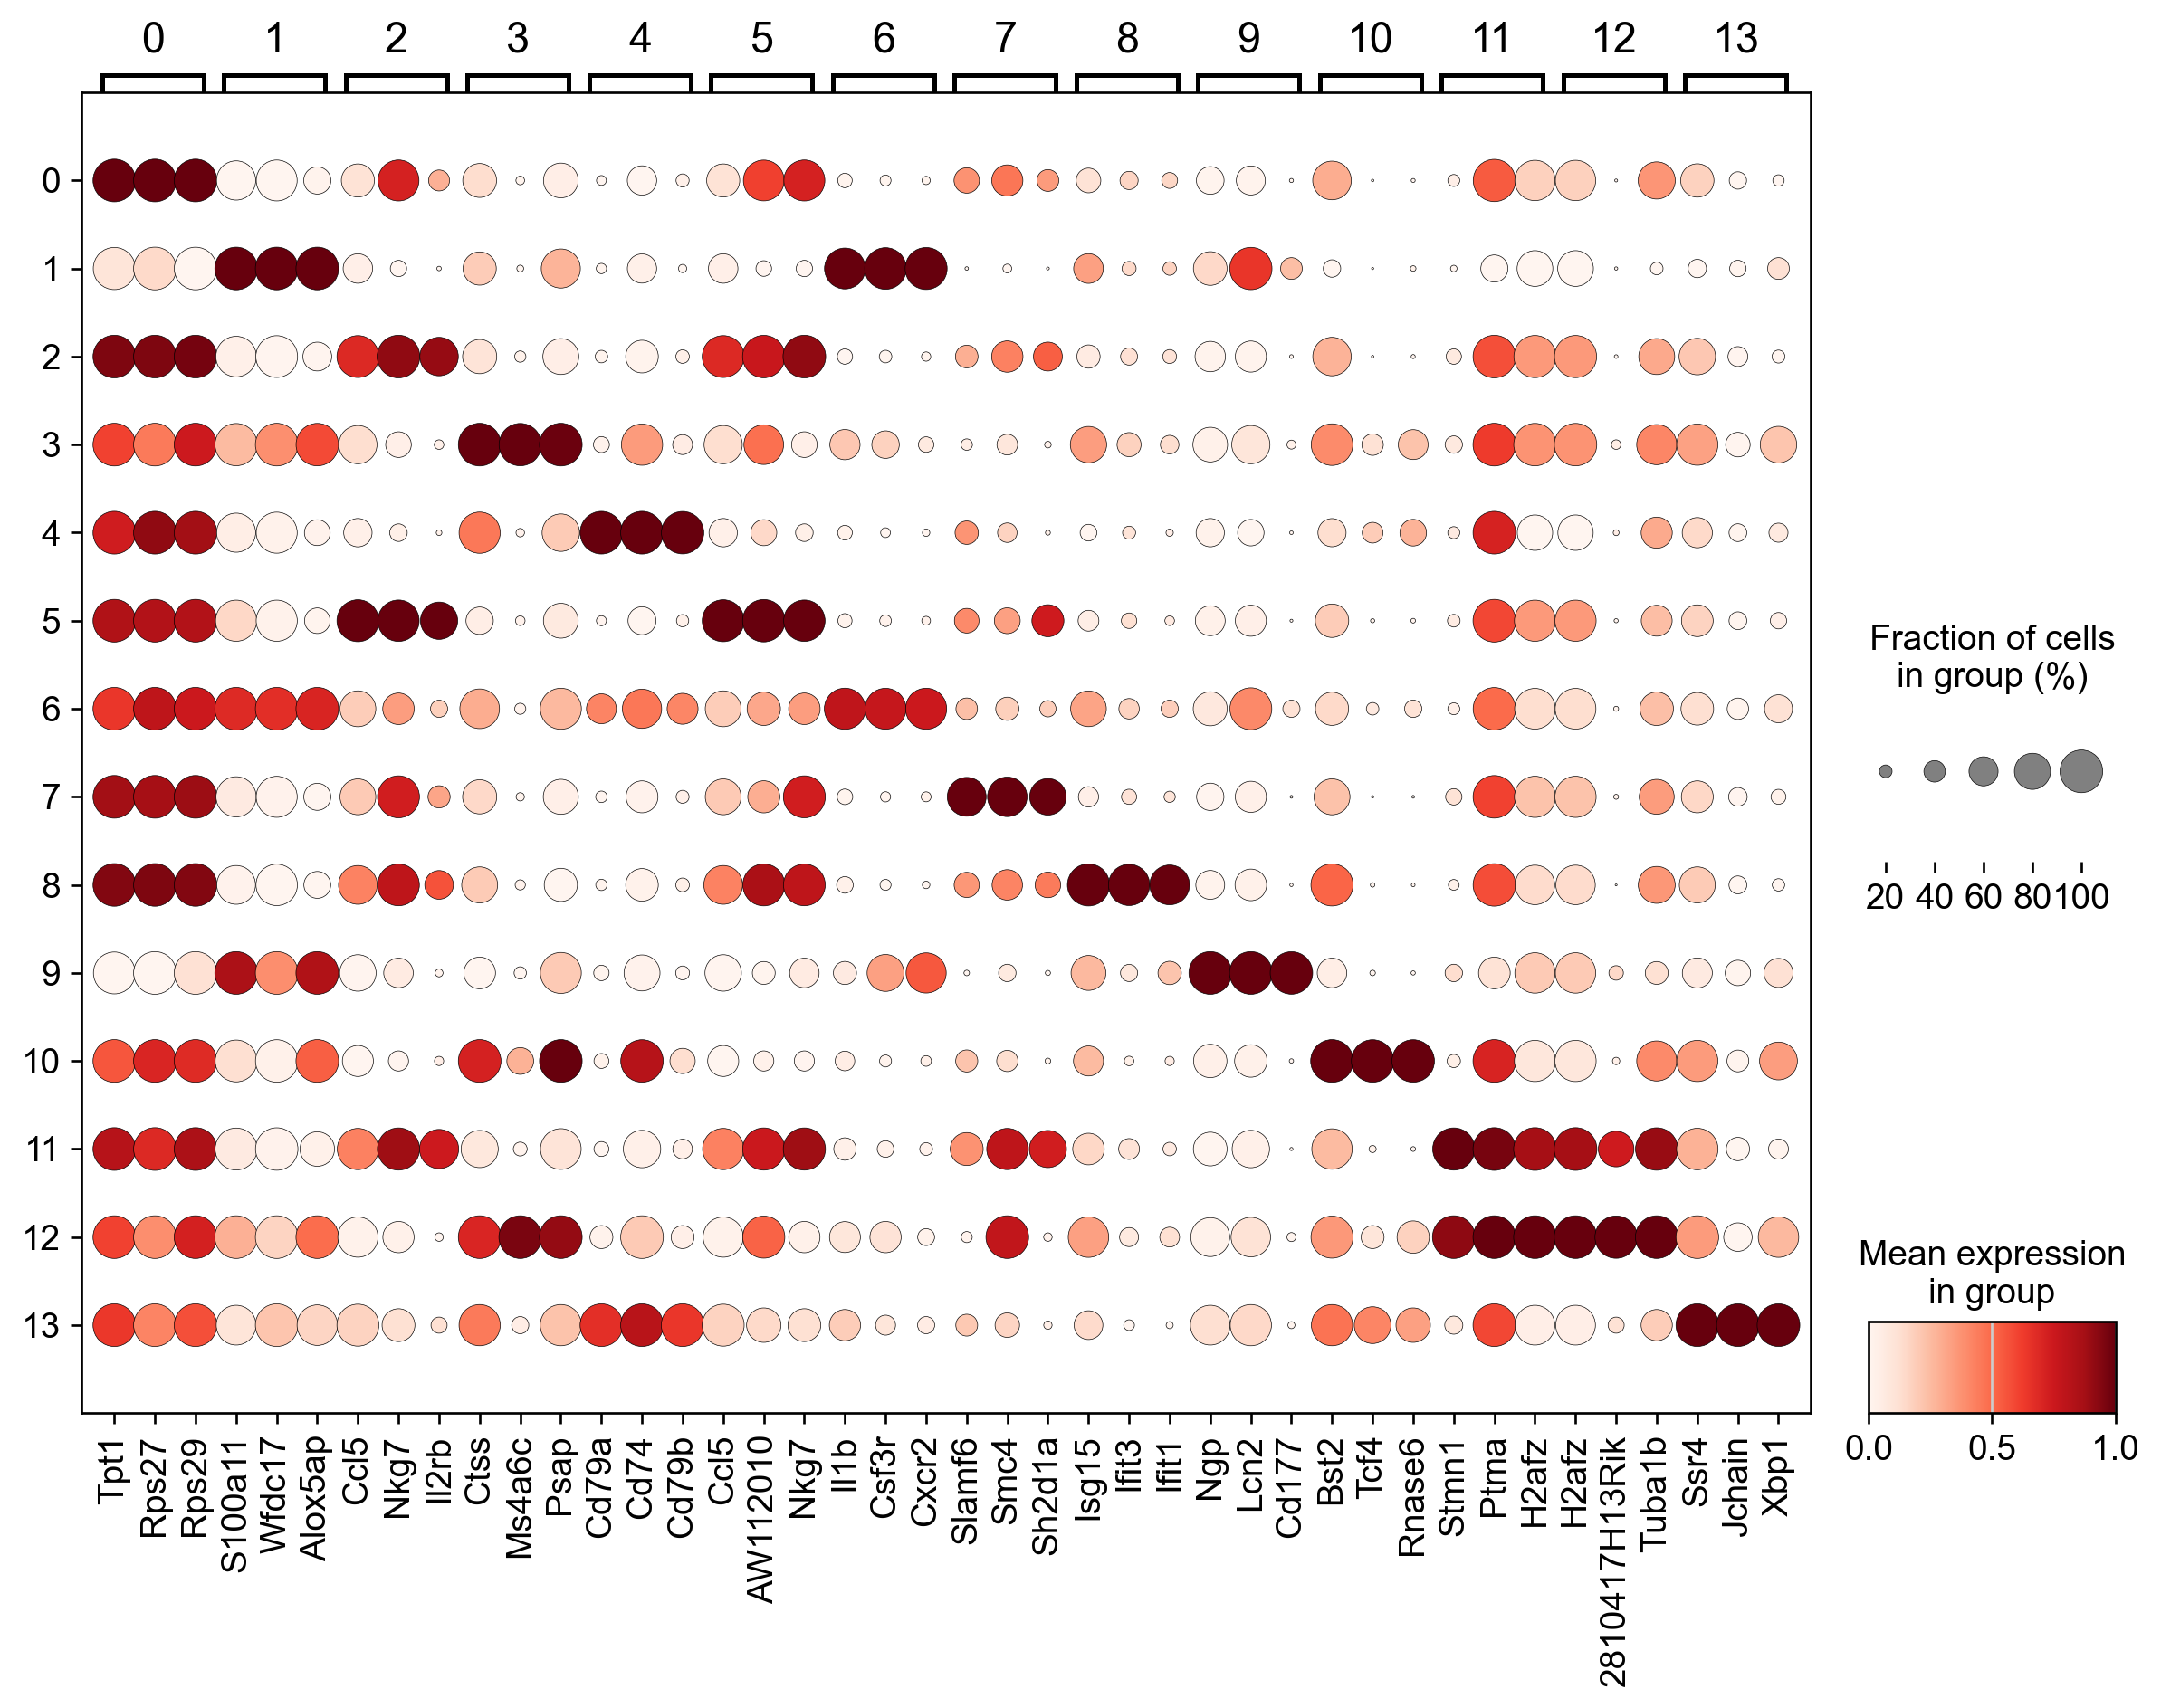

In [121]:
# Visualizar con dotplot (usando los marcadores descubiertos)
sc.pl.dotplot(
    adata,
    var_names=cluster_markers,  # diccionario {clúster: [genes]}
    groupby="leiden",
    standard_scale="var",       # escala por gen (0–1) para mejor comparación
    figsize=(12, 8),
    save='marcadores_propios.png'
)